In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import seaborn as sns

from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import warnings
warnings.filterwarnings("ignore")

colors = ["#54478c", "#2c699a", "#048ba8", "#0db39e", "#16db93", 
          "#83e377", "#b9e769", "#efea5a", "#f1c453", "#f29e4c", "#ffa62b"]

In [2]:
# Veriyi okuma
churn = pd.read_csv("churn2.csv") 

# Veriyi kopyalama
df = churn.copy() 

df.head(10)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   
5          6    15574012       Chu          645     Spain    Male   44   
6          7    15592531  Bartlett          822    France    Male   50   
7          8    15656148    Obinna          376   Germany  Female   29   
8          9    15792365        He          501    France    Male   44   
9         10    15592389        H?          684    France    Male   27   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   
5       8  113755.78              2          1               0   
6       7       0.00              2          1               1   
7       4  115046.74              4          1               0   
8       4  142051.07              2          0               1   
9       2  134603.88              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0  
5        149756.71       1  
6         10062.80       0  
7        119346.88       1  
8         74940.50       0  
9         71725.73       0

In [3]:
# Kullanılmayacak sütunları kaldırma
df = df.drop(columns = ["RowNumber", "Surname"]) 

df.head(10)

CustomerId  CreditScore Geography  Gender  Age  Tenure    Balance  \
0    15634602          619    France  Female   42       2       0.00   
1    15647311          608     Spain  Female   41       1   83807.86   
2    15619304          502    France  Female   42       8  159660.80   
3    15701354          699    France  Female   39       1       0.00   
4    15737888          850     Spain  Female   43       2  125510.82   
5    15574012          645     Spain    Male   44       8  113755.78   
6    15592531          822    France    Male   50       7       0.00   
7    15656148          376   Germany  Female   29       4  115046.74   
8    15792365          501    France    Male   44       4  142051.07   
9    15592389          684    France    Male   27       2  134603.88   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0              1          1               1        101348.88       1  
1              1          0               1        112542.58       0  
2              3          1               0        113931.57       1  
3              2          0               0         93826.63       0  
4              1          1               1         79084.10       0  
5              2          1               0        149756.71       1  
6              2          1               1         10062.80       0  
7              4          1               0        119346.88       1  
8              2          0               1         74940.50       0  
9              1          1               1         71725.73       0

In [4]:
# Sütun bilgilerini görme
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
# Verinin row ve column sayılarına bakma
df.shape 

(10000, 12)

In [6]:
# Sütunlardaki null değer sayılarının kontrolü
df.isna().sum() 

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
# Duplicated feature kontrolü
duplicated_feat = []
for i in range(0, len(df.columns)):
    col_1 = df.columns[i]

    for col_2 in df.columns[i + 1:]:
        if df[col_1].equals(df[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat) 

0

In [8]:
# Print operasyonlarında renk ve stil farklılıkları için kullanılacak class
class color: 
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
# Her sütun için unique ve number of unique değerlerini bastırma
for x in df.columns: 
    print(color.BLUE + color.BOLD + "for column: " +  color.END + x)
    print(color.BLUE + color.BOLD + "number of unique values: " + color.END + str(df[x].nunique()))
    print(color.BLUE + color.BOLD + "which are:" + color.END + str(df[x].unique()))
    print("")

for column: CustomerId
number of unique values: 10000
which are:[15634602 15647311 15619304 ... 15584532 15682355 15628319]

for column: CreditScore
number of unique values: 460
which are:[619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 

In [9]:
# Featureların istenen tiplere çevrilmesi
df["Balance"] = df["Balance"].astype("int64") 
df["EstimatedSalary"] = df["EstimatedSalary"].astype("int64")

In [10]:
# Yaş sütununun gruplara ayrılması
def age_group_calc(element): 
    if element <= 25:
        return "18-25"
    elif 25 < element <= 35:
        return "26-35"
    elif 35 < element <= 50:
        return "36-50"
    elif 50 < element:
        return "50+"

df["AgeGroup"] = df["Age"].apply(age_group_calc)

# Bakiyesi 0 olan müşterilerin ayırt edilmesi
df['IsZeroBalance'] = np.where(df['Balance'] == 0, 1, 0)

# CreditScore, EstimatedSalary ve Balance sütunların gruplara ayrılması
df["CreditScoreGroup"] = pd.qcut(df["CreditScore"], 4, labels = [0, 1 , 2, 3])
df["EstimatedSalaryGroup"] = pd.qcut(df["EstimatedSalary"], 4, labels = [0, 1 , 2, 3])
df["BalanceGroup"] = pd.qcut(df["Balance"], 5, labels = [0, 1 , 2, 3], duplicates="drop")

In [11]:
# Featureların doğru tiplere çevrilmesi

df["CustomerId"] = df["CustomerId"].astype("object")
df["NumOfProducts"] = df["NumOfProducts"].astype("object")
df["AgeGroup"] = df["AgeGroup"].astype("object")
df["CreditScoreGroup"] = df["CreditScoreGroup"].astype("object")
df["BalanceGroup"] = df["BalanceGroup"].astype("object")
df["EstimatedSalaryGroup"] = df["EstimatedSalaryGroup"].astype("object")

In [12]:
# Betimsel istatistiklerin kontrol edilmesi
df.describe().T

count         mean           std    min       25%  \
CreditScore      10000.0     650.5288     96.653299  350.0    584.00   
Age              10000.0      38.9218     10.487806   18.0     32.00   
Tenure           10000.0       5.0128      2.892174    0.0      3.00   
Balance          10000.0   76485.5715  62397.185107    0.0      0.00   
HasCrCard        10000.0       0.7055      0.455840    0.0      0.00   
IsActiveMember   10000.0       0.5151      0.499797    0.0      0.00   
EstimatedSalary  10000.0  100089.7484  57510.491042   11.0  51001.75   
Exited           10000.0       0.2037      0.402769    0.0      0.00   
IsZeroBalance    10000.0       0.3617      0.480517    0.0      0.00   

                      50%        75%       max  
CreditScore         652.0     718.00     850.0  
Age                  37.0      44.00      92.0  
Tenure                5.0       7.00      10.0  
Balance           97198.0  127643.75  250898.0  
HasCrCard             1.0       1.00       1.0  
IsActiveMember        1.0       1.00       1.0  
EstimatedSalary  100193.5  149387.75  199992.0  
Exited                0.0       0.00       1.0  
IsZeroBalance         0.0       1.00       1.0

In [13]:
# Featurelar arasındaki korelasyon değerlerine bakılması
df.corr() 

CreditScore       Age    Tenure   Balance  HasCrCard  \
CreditScore         1.000000 -0.003965  0.000842  0.006268  -0.005458   
Age                -0.003965  1.000000 -0.009997  0.028308  -0.011721   
Tenure              0.000842 -0.009997  1.000000 -0.012254   0.022583   
Balance             0.006268  0.028308 -0.012254  1.000000  -0.014858   
HasCrCard          -0.005458 -0.011721  0.022583 -0.014858   1.000000   
IsActiveMember      0.025651  0.085472 -0.028362 -0.010084  -0.011866   
EstimatedSalary    -0.001384 -0.007201  0.007784  0.012798  -0.009933   
Exited             -0.027094  0.285323 -0.014001  0.118533  -0.007138   
IsZeroBalance      -0.008380 -0.034950  0.015235 -0.922780   0.018358   

                 IsActiveMember  EstimatedSalary    Exited  IsZeroBalance  
CreditScore            0.025651        -0.001384 -0.027094      -0.008380  
Age                    0.085472        -0.007201  0.285323      -0.034950  
Tenure                -0.028362         0.007784 -0.014001       0.015235  
Balance               -0.010084         0.012798  0.118533      -0.922780  
HasCrCard             -0.011866        -0.009933 -0.007138       0.018358  
IsActiveMember         1.000000        -0.011421 -0.156128       0.004116  
EstimatedSalary       -0.011421         1.000000  0.012097      -0.014486  
Exited                -0.156128         0.012097  1.000000      -0.122357  
IsZeroBalance          0.004116        -0.014486 -0.122357       1.000000

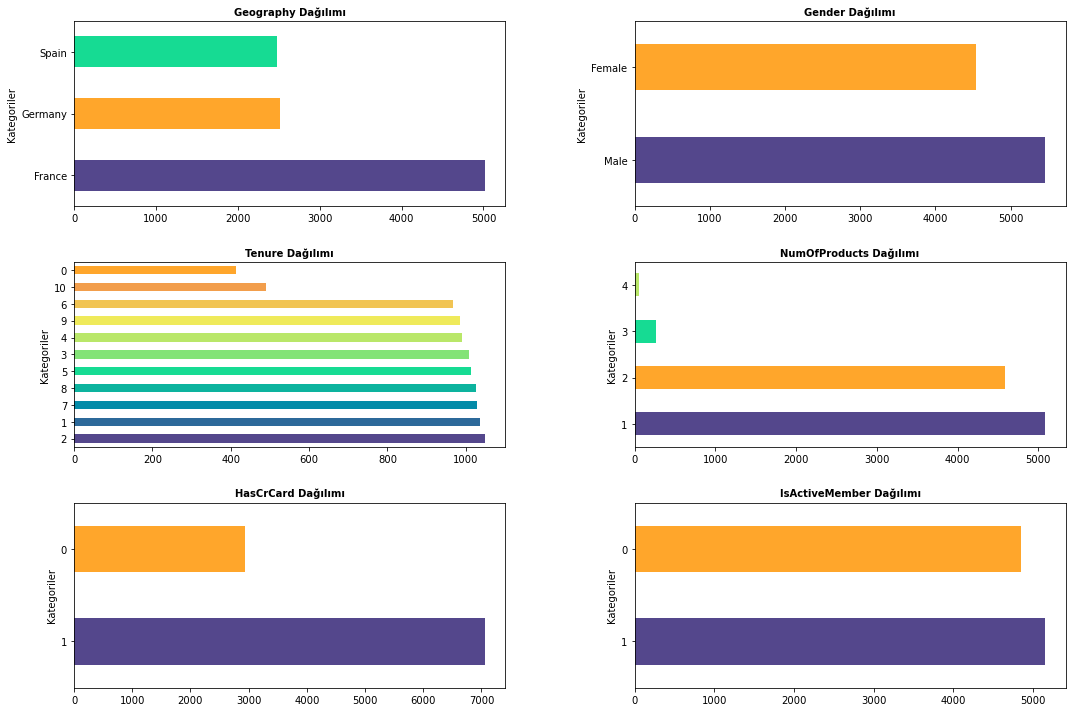

In [14]:
color_sub = ["#54478c", "#ffa62b", "#16db93", "#b9e769"]
plt.subplots(figsize = (50, 30))
      
color_temp = []
plt.subplot(3, 2, 1)
df['Geography'].value_counts().plot.barh(color = color_sub, figsize = (15, 10))
plt.title('Geography Dağılımı', fontsize = 10, fontweight = "bold")
plt.ylabel('Kategoriler')

plt.subplot(3, 2, 2)
df['Gender'].value_counts().plot.barh(color = color_sub, figsize = (15, 10))
plt.title('Gender Dağılımı', fontsize = 10, fontweight = "bold")
plt.ylabel('Kategoriler')

plt.subplot(3, 2, 3)
df['Tenure'].value_counts().plot.barh(color = colors, figsize = (15, 10))
plt.title('Tenure Dağılımı', fontsize = 10, fontweight = "bold")
plt.ylabel('Kategoriler')

plt.subplot(3, 2, 4)
df['NumOfProducts'].value_counts().plot.barh(color = color_sub, figsize = (15, 10))
plt.title('NumOfProducts Dağılımı', fontsize = 10, fontweight = "bold")
plt.ylabel('Kategoriler')

plt.subplot(3, 2, 5)
df['HasCrCard'].value_counts().plot.barh(color = color_sub, figsize = (15, 10))
plt.title('HasCrCard Dağılımı', fontsize = 10, fontweight = "bold")
plt.ylabel('Kategoriler')

plt.subplot(3, 2, 6)
df['IsActiveMember'].value_counts().plot.barh(color = color_sub, figsize = (15, 10))
plt.title('IsActiveMember Dağılımı', fontsize = 10, fontweight = "bold")
plt.ylabel('Kategoriler')

plt.tight_layout()
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.show()

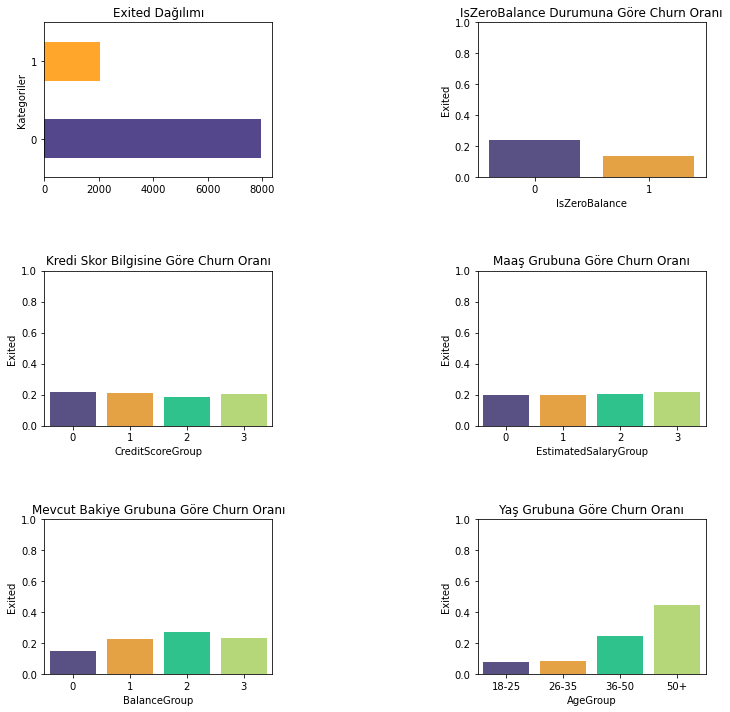

In [15]:
plot_by_age = df.groupby('AgeGroup').Exited.mean().reset_index()
plot_by_zero = df.groupby('IsZeroBalance').Exited.mean().reset_index()
plot_by_credit = df.groupby('CreditScoreGroup').Exited.mean().reset_index()
plot_by_salary = df.groupby('EstimatedSalaryGroup').Exited.mean().reset_index()
plot_by_balance = df.groupby('BalanceGroup').Exited.mean().reset_index()

plt.subplots(figsize = (10, 10))

plt.subplot(3, 2, 1)
df['Exited'].value_counts().plot.barh(color = color_sub)
plt.title('Exited Dağılımı', fontsize = 12)
plt.ylabel('Kategoriler')

plt.subplot(3, 2, 2)

sns.barplot(x = 'IsZeroBalance', y = 'Exited', data = plot_by_zero, palette = color_sub, )
plt.title("IsZeroBalance Durumuna Göre Churn Oranı", fontsize = 12) 
plt.yticks(np.arange(0, 1.2, 0.2))

plt.subplot(3, 2, 3)
sns.barplot(x = 'CreditScoreGroup', y = 'Exited', data = plot_by_credit, palette = color_sub)
plt.title("Kredi Skor Bilgisine Göre Churn Oranı", fontsize = 12)
plt.yticks(np.arange(0, 1.2, 0.2))

plt.subplot(3, 2, 4)
sns.barplot(x = 'EstimatedSalaryGroup', y = 'Exited',data = plot_by_salary ,palette = color_sub)
plt.title("Maaş Grubuna Göre Churn Oranı", fontsize = 12) 
plt.yticks(np.arange(0, 1.2, 0.2))

plt.subplot(3, 2, 5)
sns.barplot(x = 'BalanceGroup', y = 'Exited', data = plot_by_balance ,palette = color_sub)
plt.title("Mevcut Bakiye Grubuna Göre Churn Oranı", fontsize = 12) 
plt.yticks(np.arange(0, 1.2, 0.2))

plt.subplot(3, 2, 6)
sns.barplot(x = 'AgeGroup', y = 'Exited',data = plot_by_age, palette = color_sub)
plt.title("Yaş Grubuna Göre Churn Oranı", fontsize = 12) 
plt.yticks(np.arange(0, 1.2, 0.2))

plt.tight_layout()
plt.subplots_adjust(wspace = 0.9, hspace = 0.6)

plt.show()

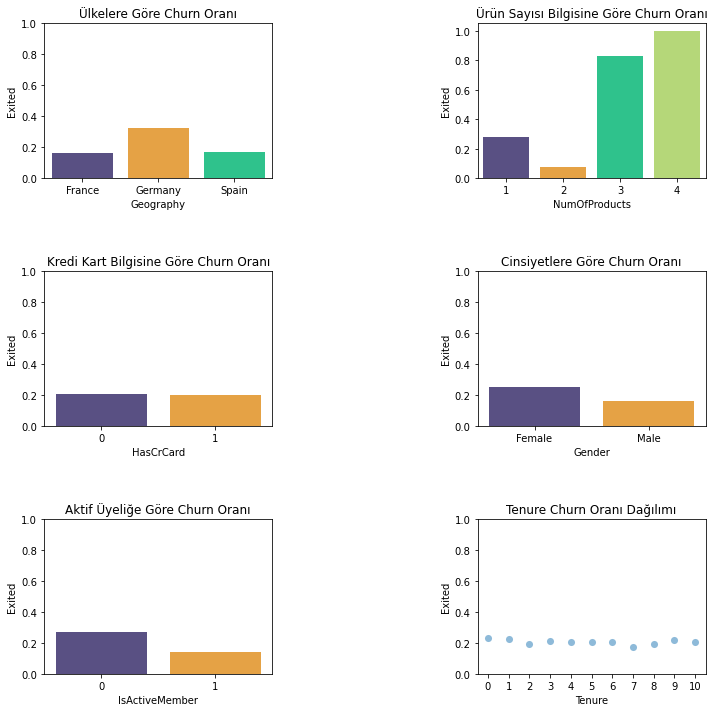

In [16]:
plot_by_active = df.groupby('IsActiveMember').Exited.mean().reset_index()
plot_by_geography = df.groupby('Geography').Exited.mean().reset_index()
plot_by_tenure = df.groupby('Tenure').Exited.mean().reset_index()
plot_by_pgroup = df.groupby('NumOfProducts').Exited.mean().reset_index()
plot_by_gender = df.groupby('Gender').Exited.mean().reset_index()
plot_by_ccard = df.groupby('HasCrCard').Exited.mean().reset_index()


plt.subplots(figsize = (10, 10))


plt.subplot(3, 2, 1)
sns.barplot(x = 'Geography', y = 'Exited',data = plot_by_geography, palette = color_sub)
plt.title("Ülkelere Göre Churn Oranı", fontsize = 12) 
plt.yticks(np.arange(0, 1.2, 0.2))


plt.subplot(3, 2, 2)
sns.barplot(x = 'NumOfProducts', y = 'Exited', data = plot_by_pgroup, palette = color_sub)
plt.title("Ürün Sayısı Bilgisine Göre Churn Oranı", fontsize = 12) 
plt.yticks(np.arange(0, 1.2, 0.2))



plt.subplot(3, 2, 3)
sns.barplot(x = 'HasCrCard', y = 'Exited',data = plot_by_ccard, palette = color_sub)
plt.title("Kredi Kart Bilgisine Göre Churn Oranı", fontsize = 12)
plt.yticks(np.arange(0, 1.2, 0.2))



plt.subplot(3, 2, 4)
sns.barplot(x = 'Gender', y = 'Exited', data = plot_by_gender ,palette = color_sub)
plt.title("Cinsiyetlere Göre Churn Oranı", fontsize = 12) 
plt.yticks(np.arange(0, 1.2, 0.2))



plt.subplot(3, 2, 5)
sns.barplot(x = 'IsActiveMember', y = 'Exited', data = plot_by_active, palette = color_sub)
plt.title("Aktif Üyeliğe Göre Churn Oranı", fontsize = 12) 
plt.yticks(np.arange(0, 1.2, 0.2))



plt.subplot(3, 2, 6)
sns.scatterplot(x = 'Tenure', y = 'Exited', data = plot_by_tenure, s = 50, linewidth = 0, alpha = 0.5)
plt.title("Tenure Churn Oranı Dağılımı", fontsize = 12)
plt.xticks(np.arange(0, 11, 1))
plt.ylim([0.15, 0.25])
plt.yticks(np.arange(0, 1.2, 0.2))


plt.tight_layout()
plt.subplots_adjust(wspace = 0.9, hspace = 0.6)

plt.show()

In [17]:
# Rare label handling
df["NumOfProducts"].replace({4 : 3}, inplace = True)
df["NumOfProducts"].value_counts()

1    5084
2    4590
3     326
Name: NumOfProducts, dtype: int64

In [18]:
# Kategorik sütunlara One Hot Encoding uygulanması
df2 = pd.get_dummies(df, columns = ['Geography', 'Gender', 'NumOfProducts', 
                                    'AgeGroup', 'BalanceGroup', 'CreditScoreGroup', 
                                    'EstimatedSalaryGroup'], drop_first = True)
df2.head(10)

CustomerId  CreditScore  Age  Tenure  Balance  HasCrCard  IsActiveMember  \
0   15634602          619   42       2        0          1               1   
1   15647311          608   41       1    83807          0               1   
2   15619304          502   42       8   159660          1               0   
3   15701354          699   39       1        0          0               0   
4   15737888          850   43       2   125510          1               1   
5   15574012          645   44       8   113755          1               0   
6   15592531          822   50       7        0          1               1   
7   15656148          376   29       4   115046          1               0   
8   15792365          501   44       4   142051          0               1   
9   15592389          684   27       2   134603          1               1   

   EstimatedSalary  Exited  IsZeroBalance  ...  AgeGroup_50+  BalanceGroup_1  \
0           101348       1              1  ...             0               0   
1           112542       0              0  ...             0               1   
2           113931       1              0  ...             0               0   
3            93826       0              1  ...             0               0   
4            79084       0              0  ...             0               0   
5           149756       1              0  ...             0               0   
6            10062       0              1  ...             0               0   
7           119346       1              0  ...             0               0   
8            74940       0              0  ...             0               0   
9            71725       0              0  ...             0               0   

   BalanceGroup_2  BalanceGroup_3  CreditScoreGroup_1  CreditScoreGroup_2  \
0               0               0                   1                   0   
1               0               0                   1                   0   
2               0               1                   0                   0   
3               0               0                   0                   1   
4               1               0                   0                   0   
5               1               0                   1                   0   
6               0               0                   0                   0   
7               1               0                   0                   0   
8               0               1                   0                   0   
9               0               1                   0                   1   

   CreditScoreGroup_3  EstimatedSalaryGroup_1  EstimatedSalaryGroup_2  \
0                   0                       0                       1   
1                   0                       0                       1   
2                   0                       0                       1   
3                   0                       1                       0   
4                   1                       1                       0   
5                   0                       0                       0   
6                   1                       0                       0   
7                   0                       0                       1   
8                   0                       1                       0   
9                   0                       1                       0   

   EstimatedSalaryGroup_3  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
5                       1  
6                       0  
7                       0  
8                       0  
9                       0  

[10 rows x 27 columns]

In [19]:
# Continous sütunlara standard scaling uygulanması
standardScaler = StandardScaler()
columns_for_ft_scaling = ['Balance', 'EstimatedSalary', 'CreditScore', 'Age', 'Tenure']

df2[columns_for_ft_scaling] = standardScaler.fit_transform(df2[columns_for_ft_scaling])
df2.head(10)

CustomerId  CreditScore       Age    Tenure   Balance  HasCrCard  \
0   15634602    -0.326221  0.293517 -1.041760 -1.225847          1   
1   15647311    -0.440036  0.198164 -1.387538  0.117342          0   
2   15619304    -1.536794  0.293517  1.032908  1.333050          1   
3   15701354     0.501521  0.007457 -1.387538 -1.225847          0   
4   15737888     2.063884  0.388871 -1.041760  0.785723          1   
5   15574012    -0.057205  0.484225  1.032908  0.597323          1   
6   15592531     1.774174  1.056346  0.687130 -1.225847          1   
7   15656148    -2.840488 -0.946079 -0.350204  0.618014          1   
8   15792365    -1.547141  0.484225 -0.350204  1.050828          0   
9   15592389     0.346319 -1.136786 -1.041760  0.931458          1   

   IsActiveMember  EstimatedSalary  Exited  IsZeroBalance  ...  AgeGroup_50+  \
0               1         0.021880       1              1  ...             0   
1               1         0.216532       0              0  ...             0   
2               0         0.240686       1              0  ...             0   
3               0        -0.108920       0              1  ...             0   
4               1        -0.365269       0              0  ...             0   
5               0         0.863647       1              0  ...             0   
6               1        -1.565493       0              1  ...             0   
7               0         0.334847       1              0  ...             0   
8               1        -0.437329       0              0  ...             0   
9               1        -0.493235       0              0  ...             0   

   BalanceGroup_1  BalanceGroup_2  BalanceGroup_3  CreditScoreGroup_1  \
0               0               0               0                   1   
1               1               0               0                   1   
2               0               0               1                   0   
3               0               0               0                   0   
4               0               1               0                   0   
5               0               1               0                   1   
6               0               0               0                   0   
7               0               1               0                   0   
8               0               0               1                   0   
9               0               0               1                   0   

   CreditScoreGroup_2  CreditScoreGroup_3  EstimatedSalaryGroup_1  \
0                   0                   0                       0   
1                   0                   0                       0   
2                   0                   0                       0   
3                   1                   0                       1   
4                   0                   1                       1   
5                   0                   0                       0   
6                   0                   1                       0   
7                   0                   0                       0   
8                   0                   0                       1   
9                   1                   0                       1   

   EstimatedSalaryGroup_2  EstimatedSalaryGroup_3  
0                       1                       0  
1                       1                       0  
2                       1                       0  
3                       0                       0  
4                       0                       0  
5                       0                       1  
6                       0                       0  
7                       1                       0  
8                       0                       0  
9                       0                       0  

[10 rows x 27 columns]

In [20]:
df_y = df2[["Exited"]]
df_x = df2.drop(columns = ["Exited"])

df_y.reset_index(inplace = True)
df_x.reset_index(inplace = True)

# Target değeri olan Exited sütununun en sona alınması
df2 = df_x.merge(df_y, left_on = "index", right_on = "index", how = "left")
df2 = df2.drop(columns = ["index"])
df2.head(10)

CustomerId  CreditScore       Age    Tenure   Balance  HasCrCard  \
0   15634602    -0.326221  0.293517 -1.041760 -1.225847          1   
1   15647311    -0.440036  0.198164 -1.387538  0.117342          0   
2   15619304    -1.536794  0.293517  1.032908  1.333050          1   
3   15701354     0.501521  0.007457 -1.387538 -1.225847          0   
4   15737888     2.063884  0.388871 -1.041760  0.785723          1   
5   15574012    -0.057205  0.484225  1.032908  0.597323          1   
6   15592531     1.774174  1.056346  0.687130 -1.225847          1   
7   15656148    -2.840488 -0.946079 -0.350204  0.618014          1   
8   15792365    -1.547141  0.484225 -0.350204  1.050828          0   
9   15592389     0.346319 -1.136786 -1.041760  0.931458          1   

   IsActiveMember  EstimatedSalary  IsZeroBalance  Geography_Germany  ...  \
0               1         0.021880              1                  0  ...   
1               1         0.216532              0                  0  ...   
2               0         0.240686              0                  0  ...   
3               0        -0.108920              1                  0  ...   
4               1        -0.365269              0                  0  ...   
5               0         0.863647              0                  0  ...   
6               1        -1.565493              1                  0  ...   
7               0         0.334847              0                  1  ...   
8               1        -0.437329              0                  0  ...   
9               1        -0.493235              0                  0  ...   

   BalanceGroup_1  BalanceGroup_2  BalanceGroup_3  CreditScoreGroup_1  \
0               0               0               0                   1   
1               1               0               0                   1   
2               0               0               1                   0   
3               0               0               0                   0   
4               0               1               0                   0   
5               0               1               0                   1   
6               0               0               0                   0   
7               0               1               0                   0   
8               0               0               1                   0   
9               0               0               1                   0   

   CreditScoreGroup_2  CreditScoreGroup_3  EstimatedSalaryGroup_1  \
0                   0                   0                       0   
1                   0                   0                       0   
2                   0                   0                       0   
3                   1                   0                       1   
4                   0                   1                       1   
5                   0                   0                       0   
6                   0                   1                       0   
7                   0                   0                       0   
8                   0                   0                       1   
9                   1                   0                       1   

   EstimatedSalaryGroup_2  EstimatedSalaryGroup_3  Exited  
0                       1                       0       1  
1                       1                       0       0  
2                       1                       0       1  
3                       0                       0       0  
4                       0                       0       0  
5                       0                       1       1  
6                       0                       0       0  
7                       1                       0       1  
8                       0                       0       0  
9                       0                       0       0  

[10 rows x 27 columns]

Text(0.5, 1.0, 'Correlation Değerlerini göstermek için Heatmap')

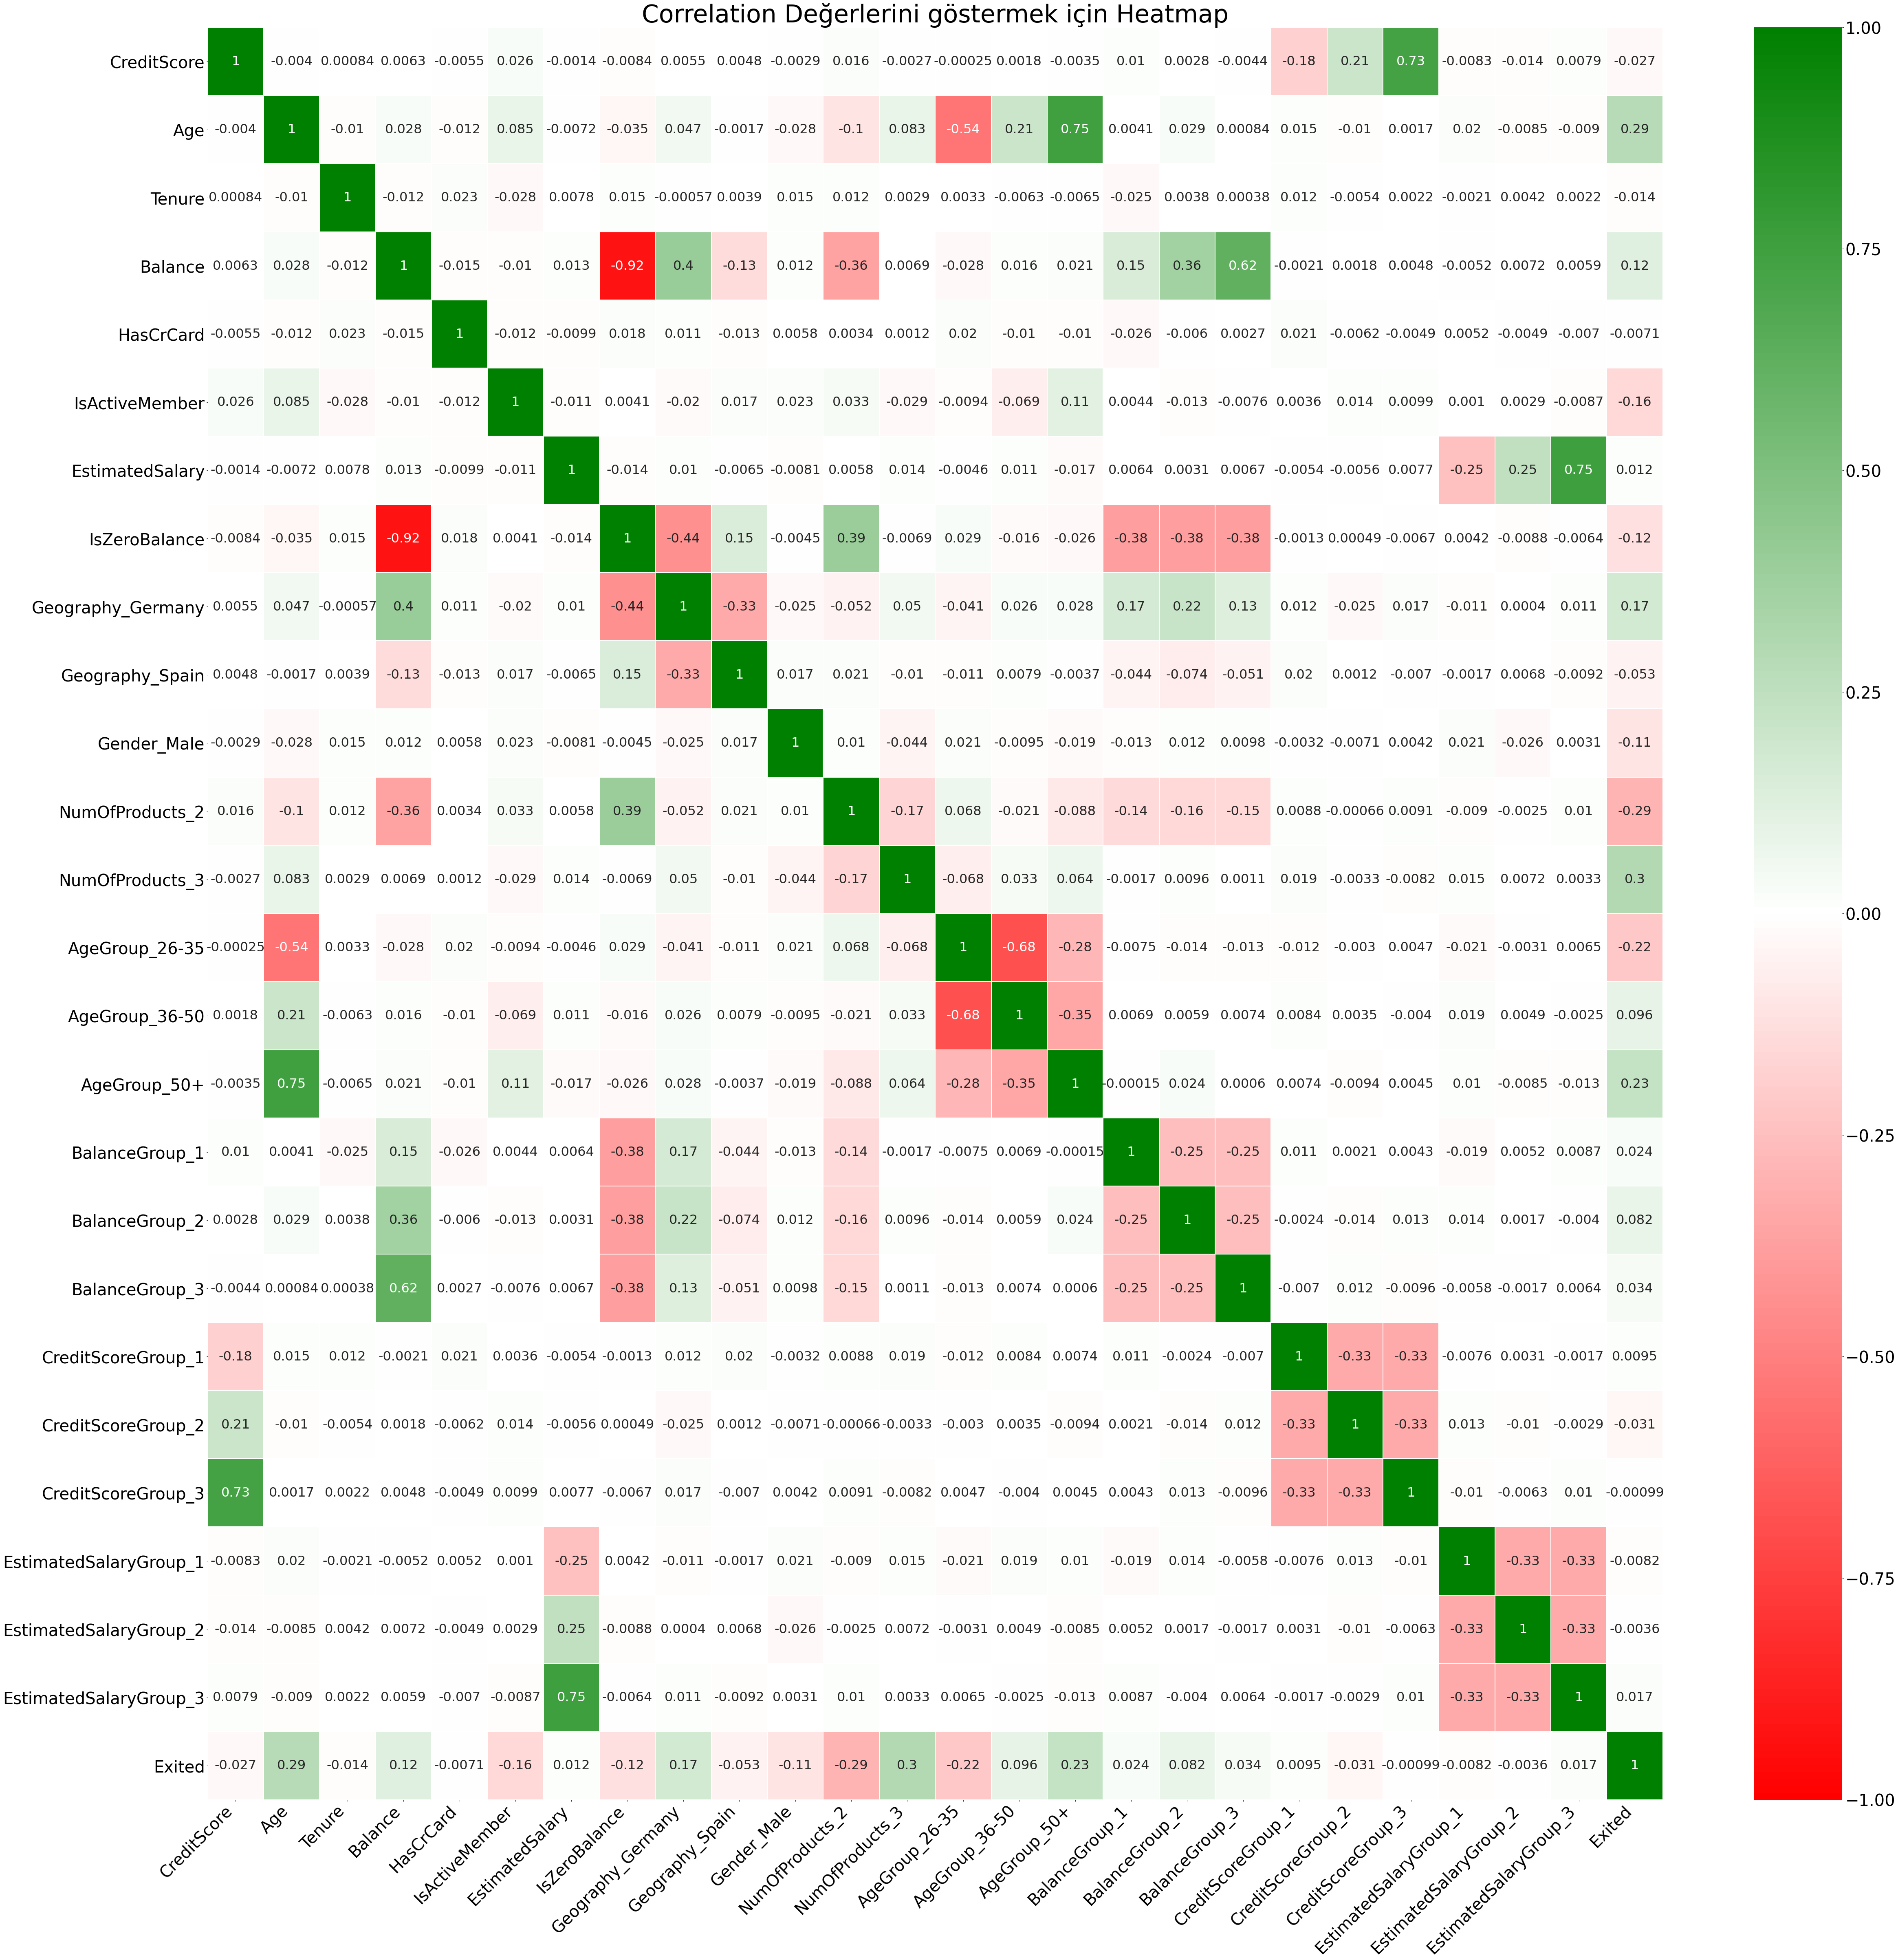

In [21]:
cmap = LinearSegmentedColormap.from_list(name = "rwg", colors = ['red', 'white', 'green'])

f, ax = plt.subplots(figsize = (80, 80))
sns.heatmap(df2.corr(), linewidths = 1, annot = True, cmap = cmap, annot_kws = {'size' : 32}, vmax = 1, vmin = -1)

plt.yticks(rotation = 0, ha = 'right', fontsize = 40)
plt.xticks(rotation = 45, ha = 'right', fontsize = 40)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize = 40)

ax.set_title('Correlation Değerlerini göstermek için Heatmap', fontsize = 60)

In [22]:
# Azınlıkta olan 1 değerindeki satırların "oversampling" ile 0 olan değerler ile eşit sayıya getirilmesi
zeros = df2[df2['Exited'] == 0]
ones = df2[df2['Exited'] == 1]

ones_oversampled = resample(ones, replace = True, n_samples = len(zeros), random_state = 42)

df3 = pd.concat([zeros, ones_oversampled])
df3

CustomerId  CreditScore       Age    Tenure   Balance  HasCrCard  \
1      15647311    -0.440036  0.198164 -1.387538  0.117342          0   
3      15701354     0.501521  0.007457 -1.387538 -1.225847          0   
4      15737888     2.063884  0.388871 -1.041760  0.785723          1   
6      15592531     1.774174  1.056346  0.687130 -1.225847          1   
8      15792365    -1.547141  0.484225 -0.350204  1.050828          0   
...         ...          ...       ...       ...       ...        ...   
5701   15724154    -0.264141  0.960993 -0.350204  0.833708          1   
9337   15797751    -1.909278  0.770285 -0.004426  0.410286          1   
4345   15584536     0.718803  0.674932 -0.695982  0.329461          1   
1085   15646513     1.577585  0.293517 -0.004426 -1.225847          1   
3694   15609704    -0.440036 -0.564665 -0.350204 -1.225847          1   

      IsActiveMember  EstimatedSalary  IsZeroBalance  Geography_Germany  ...  \
1                  1         0.216532              0                  0  ...   
3                  0        -0.108920              1                  0  ...   
4                  1        -0.365269              0                  0  ...   
6                  1        -1.565493              1                  0  ...   
8                  1        -0.437329              0                  0  ...   
...              ...              ...            ...                ...  ...   
5701               0         0.464673              0                  1  ...   
9337               1         1.451047              0                  1  ...   
4345               1         0.581249              0                  1  ...   
1085               0         1.675887              1                  0  ...   
3694               0        -0.361443              1                  0  ...   

      BalanceGroup_1  BalanceGroup_2  BalanceGroup_3  CreditScoreGroup_1  \
1                  1               0               0                   1   
3                  0               0               0                   0   
4                  0               1               0                   0   
6                  0               0               0                   0   
8                  0               0               1                   0   
...              ...             ...             ...                 ...   
5701               0               1               0                   1   
9337               1               0               0                   0   
4345               1               0               0                   0   
1085               0               0               0                   0   
3694               0               0               0                   1   

      CreditScoreGroup_2  CreditScoreGroup_3  EstimatedSalaryGroup_1  \
1                      0                   0                       0   
3                      1                   0                       1   
4                      0                   1                       1   
6                      0                   1                       0   
8                      0                   0                       1   
...                  ...                 ...                     ...   
5701                   0                   0                       0   
9337                   0                   0                       0   
4345                   0                   1                       0   
1085                   0                   1                       0   
3694                   0                   0                       1   

      EstimatedSalaryGroup_2  EstimatedSalaryGroup_3  Exited  
1                          1                       0       0  
3                          0                       0       0  
4                          0                       0       0  
6                          0                       0       0  
8                          0                       0       0  
...        

Text(0.5, 1.0, 'Correlation Değerlerini göstermek için Heatmap')

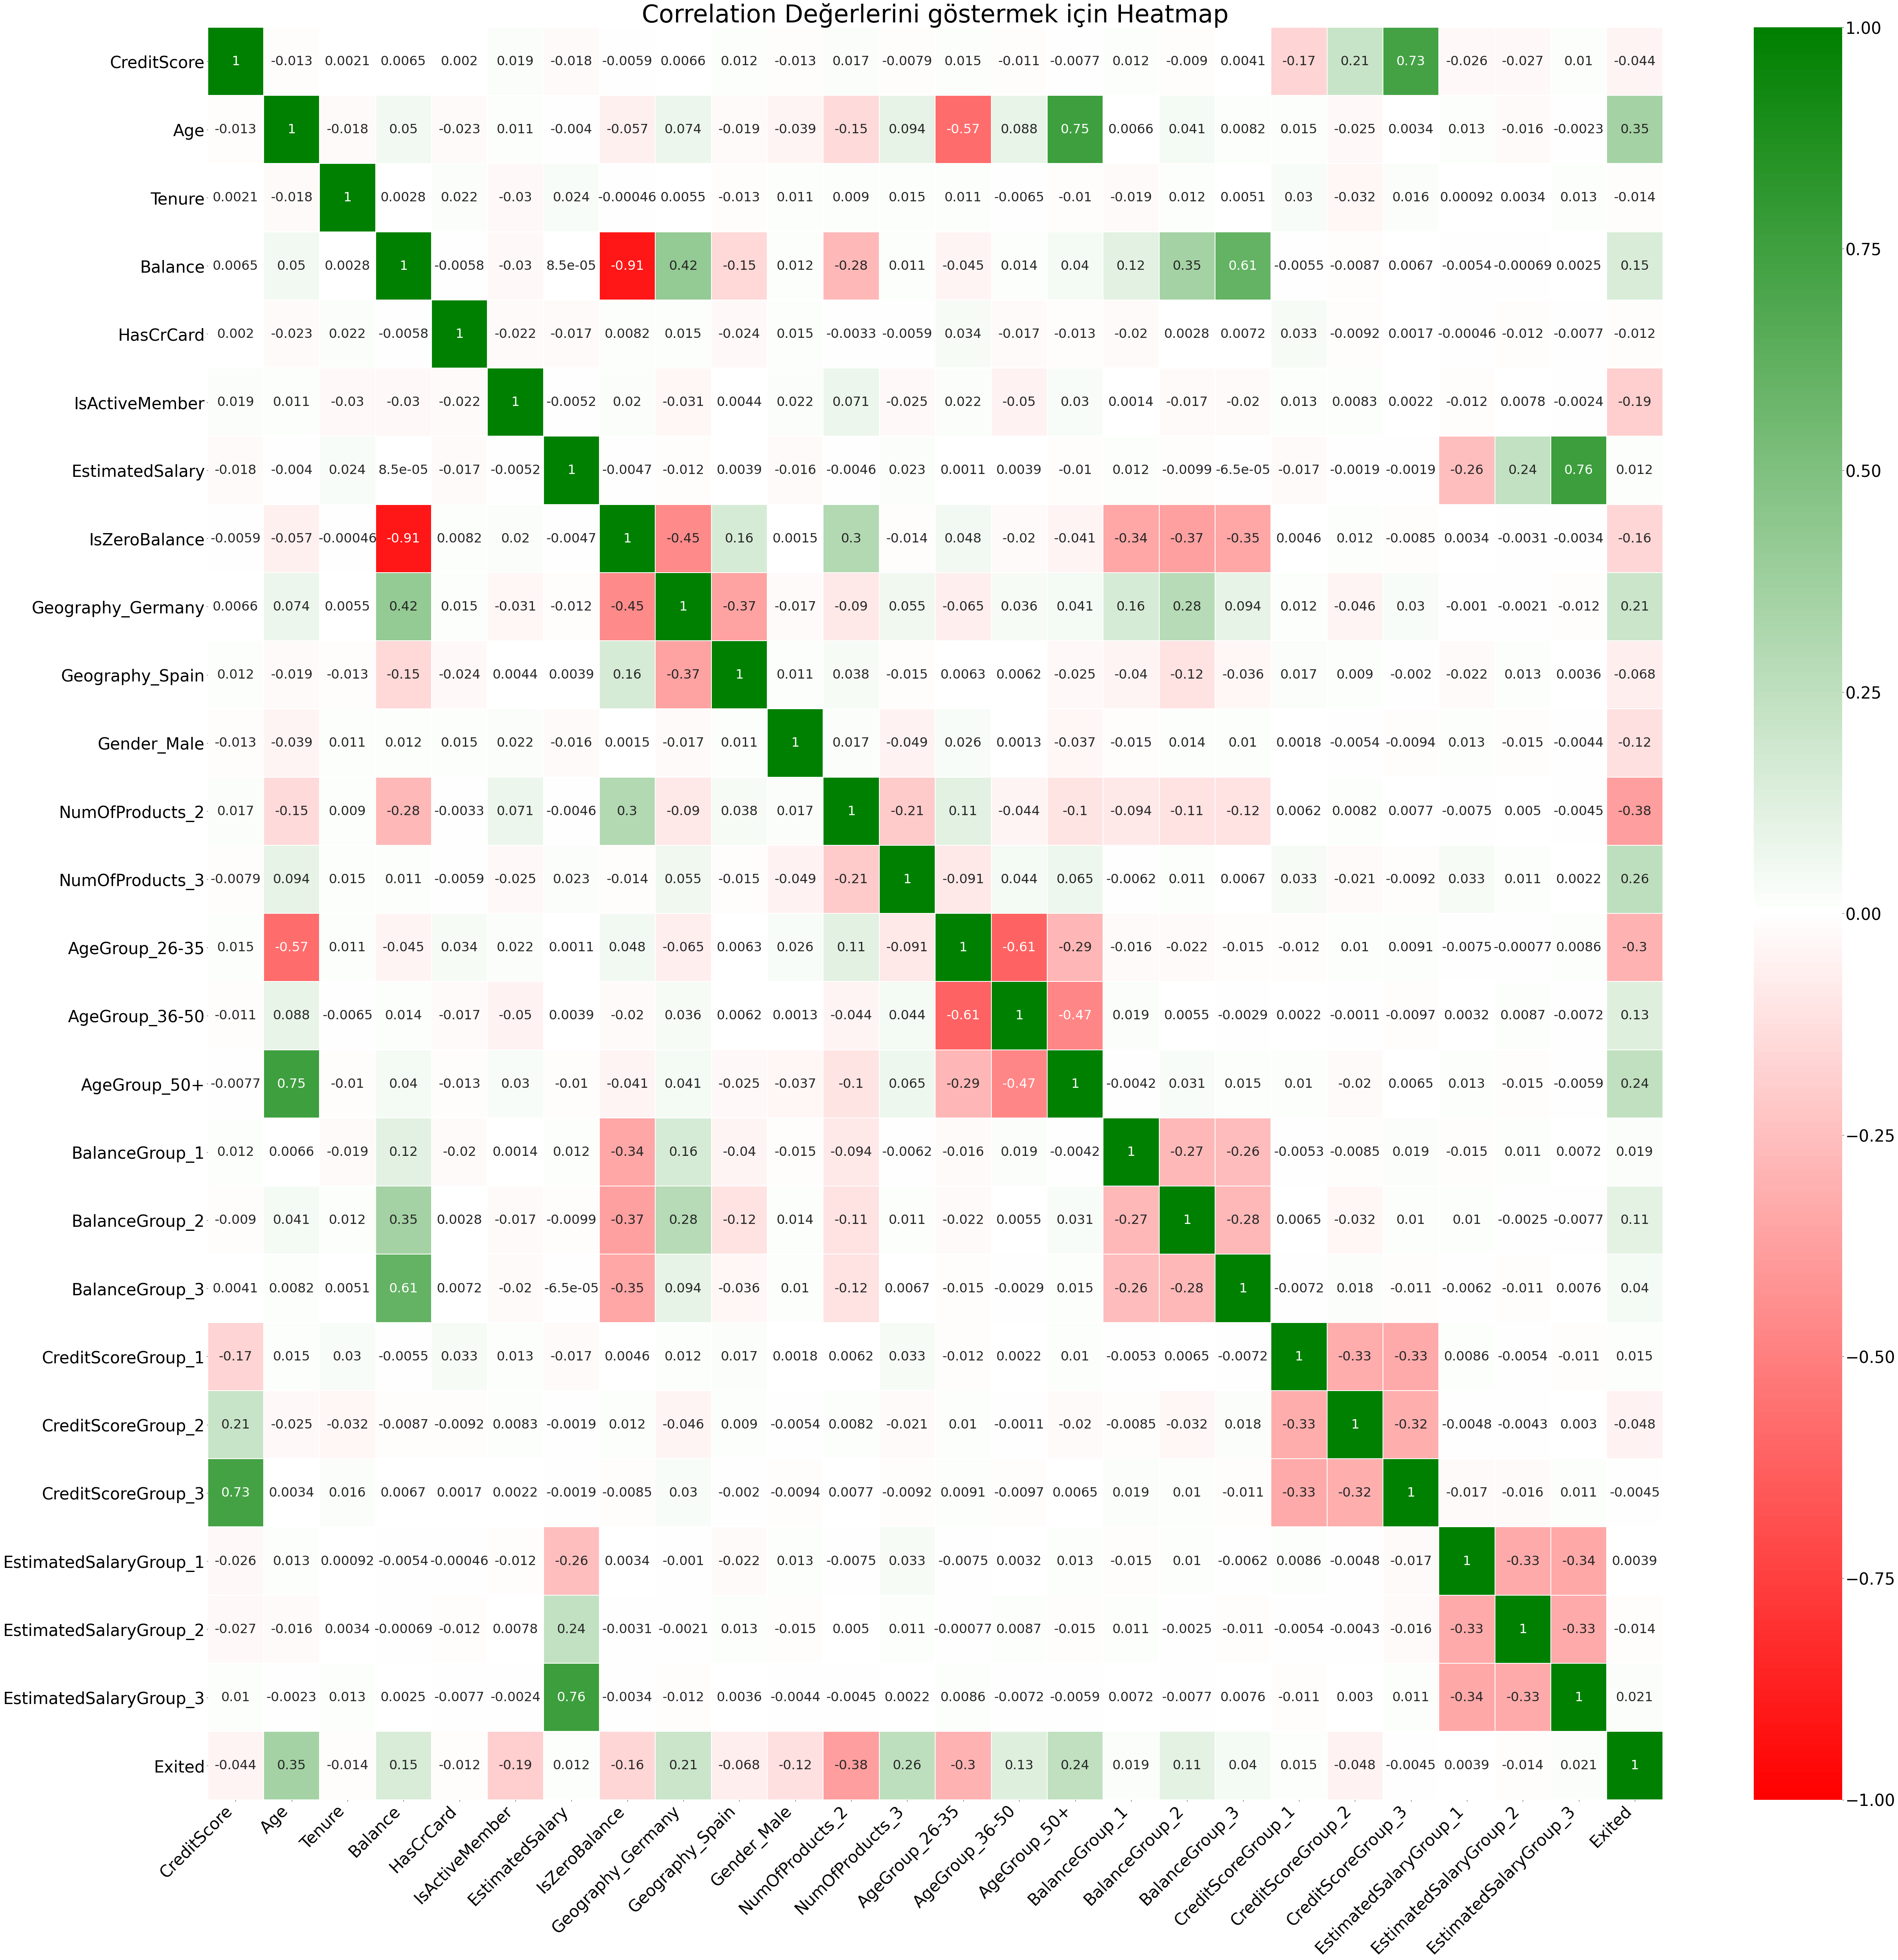

In [23]:
# Oversampling sonrası korelasyonların yeniden kontrolü
cmap = LinearSegmentedColormap.from_list(name = "rwg", colors = ['red', 'white', 'green'])

f, ax = plt.subplots(figsize = (80, 80))
sns.heatmap(df3.corr(), linewidths = 1, annot = True, cmap = cmap, annot_kws = {'size' : 32}, vmax = 1, vmin = -1)

plt.yticks(rotation = 0, ha = 'right', fontsize = 40)
plt.xticks(rotation = 45, ha = 'right', fontsize = 40)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize = 40)

ax.set_title('Correlation Değerlerini göstermek için Heatmap', fontsize = 60)

In [24]:
# Shuffling
df3 = shuffle(df3, random_state = 42)
df3 = df3.reset_index(drop = True)

# Verinin X, y olarak ayrılması
y = df3['Exited']
X = df3.drop(['Exited', 'CustomerId'], axis = 1)

#Verinin train ve validation olarak bölünmesi(%70 - %30)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

### Model Oluşturulma ve Çalıştırma

In [25]:
# Random Forest ile en önemli 15 değişkenin belirlenmesi
sfs = SFS(RandomForestClassifier(n_estimators = 10, n_jobs = 4, random_state = 42), 
           k_features = 15, # the more features we want, the longer it will take to run
           forward = True, 
           floating = False, 
           verbose = 2, # this indicates how much to print out intermediate steps
           scoring = 'roc_auc',
           cv = 2)

sfs = sfs.fit(np.array(X_train), y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    6.0s finished

[2021-09-15 14:09:52] Features: 1/15 -- score: 0.7552722221821654[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.4s finished

[2021-09-15 14:09:55] Features: 2/15 -- score: 0.8342397728056956[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    2.7s finished

[2021-09-15 14:09:58] Features: 3/15 -- score: 0.885584712203724[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

In [26]:
# Seçilen en önemli 15 değerin bastırılması
selected_feat = X_train.columns[list(sfs.k_feature_idx_)]
selected_feat

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember',
       'EstimatedSalary', 'IsZeroBalance', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male', 'NumOfProducts_2', 'NumOfProducts_3',
       'AgeGroup_26-35', 'CreditScoreGroup_1', 'CreditScoreGroup_2'],
      dtype='object')

In [27]:
# Mevcut sütunların bastırılması
X.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'IsZeroBalance',
       'Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'NumOfProducts_2', 'NumOfProducts_3', 'AgeGroup_26-35',
       'AgeGroup_36-50', 'AgeGroup_50+', 'BalanceGroup_1', 'BalanceGroup_2',
       'BalanceGroup_3', 'CreditScoreGroup_1', 'CreditScoreGroup_2',
       'CreditScoreGroup_3', 'EstimatedSalaryGroup_1',
       'EstimatedSalaryGroup_2', 'EstimatedSalaryGroup_3'],
      dtype='object')

In [28]:
# Önemli değişkenlerin filtrelenmesi
X_temp = X[['CreditScore', 'Age', 'Tenure', 'IsActiveMember', 'HasCrCard',
            'EstimatedSalary', 'IsZeroBalance', 'Geography_Germany', 'Geography_Spain', 
            'Gender_Male', 'NumOfProducts_2', 'NumOfProducts_3', 'Balance']]

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size = 0.30, random_state = 42)

In [29]:
# Fit the Decision Tree Classification Model
dtmodel = DecisionTreeClassifier(criterion = "gini", random_state = 42)
dtmodel.fit(X_train, y_train) 
  
# Predict the value for new, unseen data
dt_pred = dtmodel.predict(X_test)

# Find Accuracy using accuracy_score method
dt_accuracy = round(metrics.accuracy_score(y_test, dt_pred) * 100, 2)

In [30]:
# Fit the Random Forest Classification Model
rf_model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
rf_model.fit(X_train, y_train) 
  
# Predict the value for new, unseen data
rf_pred = rf_model.predict(X_test)

# Find Accuracy using accuracy_score method
rf_accuracy = round(metrics.accuracy_score(y_test, rf_pred) * 100, 2)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

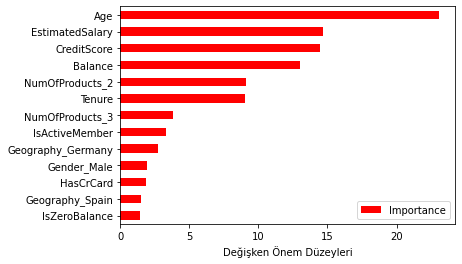

In [31]:
# Değişkenlerin önem seviyesinin Random Forest ile belirlenmesi
Importance = pd.DataFrame({"Importance": rf_model.feature_importances_ * 100},
                         index = X_train.columns)
 

Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind = "barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

In [32]:
# Fit the GBM Model
gbm_model = GradientBoostingClassifier(random_state = 42).fit(X_train, y_train)

# Predict the value for new, unseen data
gbm_pred = gbm_model.predict(X_test)

# Find Accuracy using accuracy_score method
gbm_accuracy = round(metrics.accuracy_score(y_test, gbm_pred) * 100, 2)
gbm_accuracy

79.53

In [33]:
# Fit the GBM Model
xgb_model = XGBClassifier(random_state = 42).fit(X_train, y_train)

# Predict the value for new, unseen data
xgb_pred = xgb_model.predict(X_test)

# Find Accuracy using accuracy_score method
xgb_accuracy = round(metrics.accuracy_score(y_test, xgb_pred) * 100, 2)
xgb_accuracy

[14:10:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


88.89

In [34]:
# Fit the GBM Model
lgbm_model = LGBMClassifier(random_state = 42).fit(X_train, y_train)

# Predict the value for new, unseen data
lgbm_pred = lgbm_model.predict(X_test)

# Find Accuracy using accuracy_score method
lgbm_accuracy = round(metrics.accuracy_score(y_test, lgbm_pred) * 100, 2)
lgbm_accuracy

85.35

In [35]:
# Fit the GBM Model
cat_model = CatBoostClassifier(random_state = 42).fit(X_train, y_train, logging_level = 'Silent')

# Predict the value for new, unseen data
cat_pred = cat_model.predict(X_test)

# Find Accuracy using accuracy_score method
cat_accuracy = round(metrics.accuracy_score(y_test, cat_pred) * 100, 2)
cat_accuracy

85.41

In [36]:
rf1 = RandomForestClassifier(max_depth = 200, n_estimators = 151, n_jobs = -1, max_features = 'log2', 
                             min_samples_split = 5, min_samples_leaf = 1, random_state = 42)

ada_model = AdaBoostClassifier(base_estimator = rf1, random_state = 42, n_estimators = 101)
ada_model.fit(X_train, y_train)

ada_pred = ada_model.predict(X_test)

ada_accuracy = round(metrics.accuracy_score(y_test, ada_pred) * 100, 2)
ada_accuracy

94.01

In [50]:
# Model accuracylerinin kıyaslanması
Model_Comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'GBM', 'AdaBoost with RF', 'XGBoost', 'Light GBM', 'CatBoost'],
    'Score': [dt_accuracy, rf_accuracy, gbm_accuracy, ada_accuracy, 
              xgb_accuracy, lgbm_accuracy, cat_accuracy]})

Model_Comparison_df = Model_Comparison.sort_values(by = 'Score', ascending = False)
Model_Comparison_df = Model_Comparison_df.set_index('Score')

Model_Comparison_df.reset_index()

Score             Model
0  94.06     Random Forest
1  94.01  AdaBoost with RF
2  90.56     Decision Tree
3  88.89           XGBoost
4  85.41          CatBoost
5  85.35         Light GBM
6  79.53               GBM

### Aynı Modellerin Tune Edilmiş Parametreler ile yeniden Çalıştırılması

In [51]:
rf_tuned = RandomForestClassifier(max_depth = 100 ,
                                  max_features = 2 ,
                                  min_samples_split = 2,
                                  n_estimators = 1000,
                                  min_samples_leaf = 1,
                                  random_state = 42)

rf_tuned.fit(X_train, y_train)
rf_tuned_pred = rf_tuned.predict(X_test)
rf_tuned_accuracy = round(metrics.accuracy_score(y_test, rf_tuned_pred) * 100, 2)
rf_tuned_accuracy

94.1

In [52]:
ada_rf_tuned = AdaBoostClassifier(base_estimator = rf_tuned, n_estimators = 101, random_state = 42) 

ada_rf_tuned.fit(X_train, y_train)
ada_rf_tuned_pred = ada_rf_tuned.predict(X_test)
ada_rf_tuned_accuracy = round(metrics.accuracy_score(y_test, ada_rf_tuned_pred) * 100, 2) 
ada_rf_tuned_accuracy

93.97

In [53]:
gbm = GradientBoostingClassifier(learning_rate = 0.1,
                                 max_depth = 100,
                                 min_samples_split = 5,
                                 n_estimators = 1000,
                                 random_state = 42)

gbm_tuned = gbm.fit(X_train, y_train)
gbm_tuned_pred = gbm_tuned.predict(X_test)
gbm_tuned_accuracy = round(metrics.accuracy_score(y_test, gbm_tuned_pred) * 100, 2)
gbm_tuned_accuracy

95.67

In [54]:
xgb = XGBClassifier(learning_rate = 0.01,
                    max_depth = 50,
                    min_samples_split = 2,
                    n_estimators = 2000,
                    subsample = 0.6,
                    random_state = 42)

xgb_tuned =  xgb.fit(X_train, y_train)
xgb_tuned_pred = xgb_tuned.predict(X_test)
xgb_tuned_accuracy=round(metrics.accuracy_score(y_test, xgb_tuned_pred) * 100, 2)
xgb_tuned_accuracy

[14:27:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_split" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:27:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


93.72

In [55]:
lgbm = LGBMClassifier(learning_rate = 0.1,
                      max_depth = 50,
                      subsample = 0.3,
                      n_estimators = 2000,
                      min_child_samples = 5,
                      random_state = 42)

lgbm_tuned = lgbm.fit(X_train, y_train)
lgbm_pred = lgbm_tuned.predict(X_test)
lgbm_tuned_accuracy = round(metrics.accuracy_score(y_test, lgbm_pred) * 100, 2)
lgbm_tuned_accuracy

94.04

In [56]:
cat = CatBoostClassifier(iterations = 1000,
                          learning_rate = 0.1,
                          depth = 8,
                          random_state = 42)

cat_tuned = cat.fit(X_train, y_train, logging_level = 'Silent')
cat_tuned_pred = cat_tuned.predict(X_test)
cat_tuned_accuracy = round(metrics.accuracy_score(y_test, cat_tuned_pred) * 100, 2)
cat_tuned_accuracy

93.34

In [57]:
# Tune edilmiş modellerin accuracy değerlerinin karşılaştırılması
Model_Comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Adaboost with RF', 'GBM', 'XGBoost', 'Light GBM', 'CatBoost'],
    'Score': [rf_tuned_accuracy, ada_rf_tuned_accuracy, gbm_tuned_accuracy, 
              xgb_tuned_accuracy, lgbm_tuned_accuracy, cat_tuned_accuracy]})

Model_Comparison_df = Model_Comparison.sort_values(by = 'Score', ascending = False)
Model_Comparison_df = Model_Comparison_df.set_index('Score')
Model_Comparison_df.reset_index()

Score             Model
0  95.67               GBM
1  94.10     Random Forest
2  94.04         Light GBM
3  93.97  Adaboost with RF
4  93.72           XGBoost
5  93.34          CatBoost

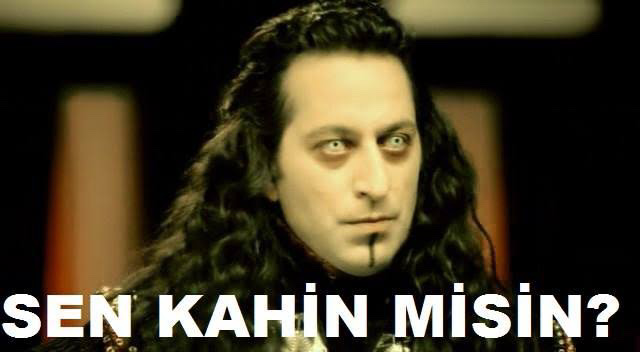

In [58]:
from IPython.display import Image
Image("kahin.jpg", width = 400, height = 100)

In [59]:
# Confusion Matrix
conf_mat_gbmmodel = confusion_matrix(y_test, gbm_tuned_pred)
conf_mat_gbmmodel

array([[2310,  129],
       [  78, 2261]], dtype=int64)

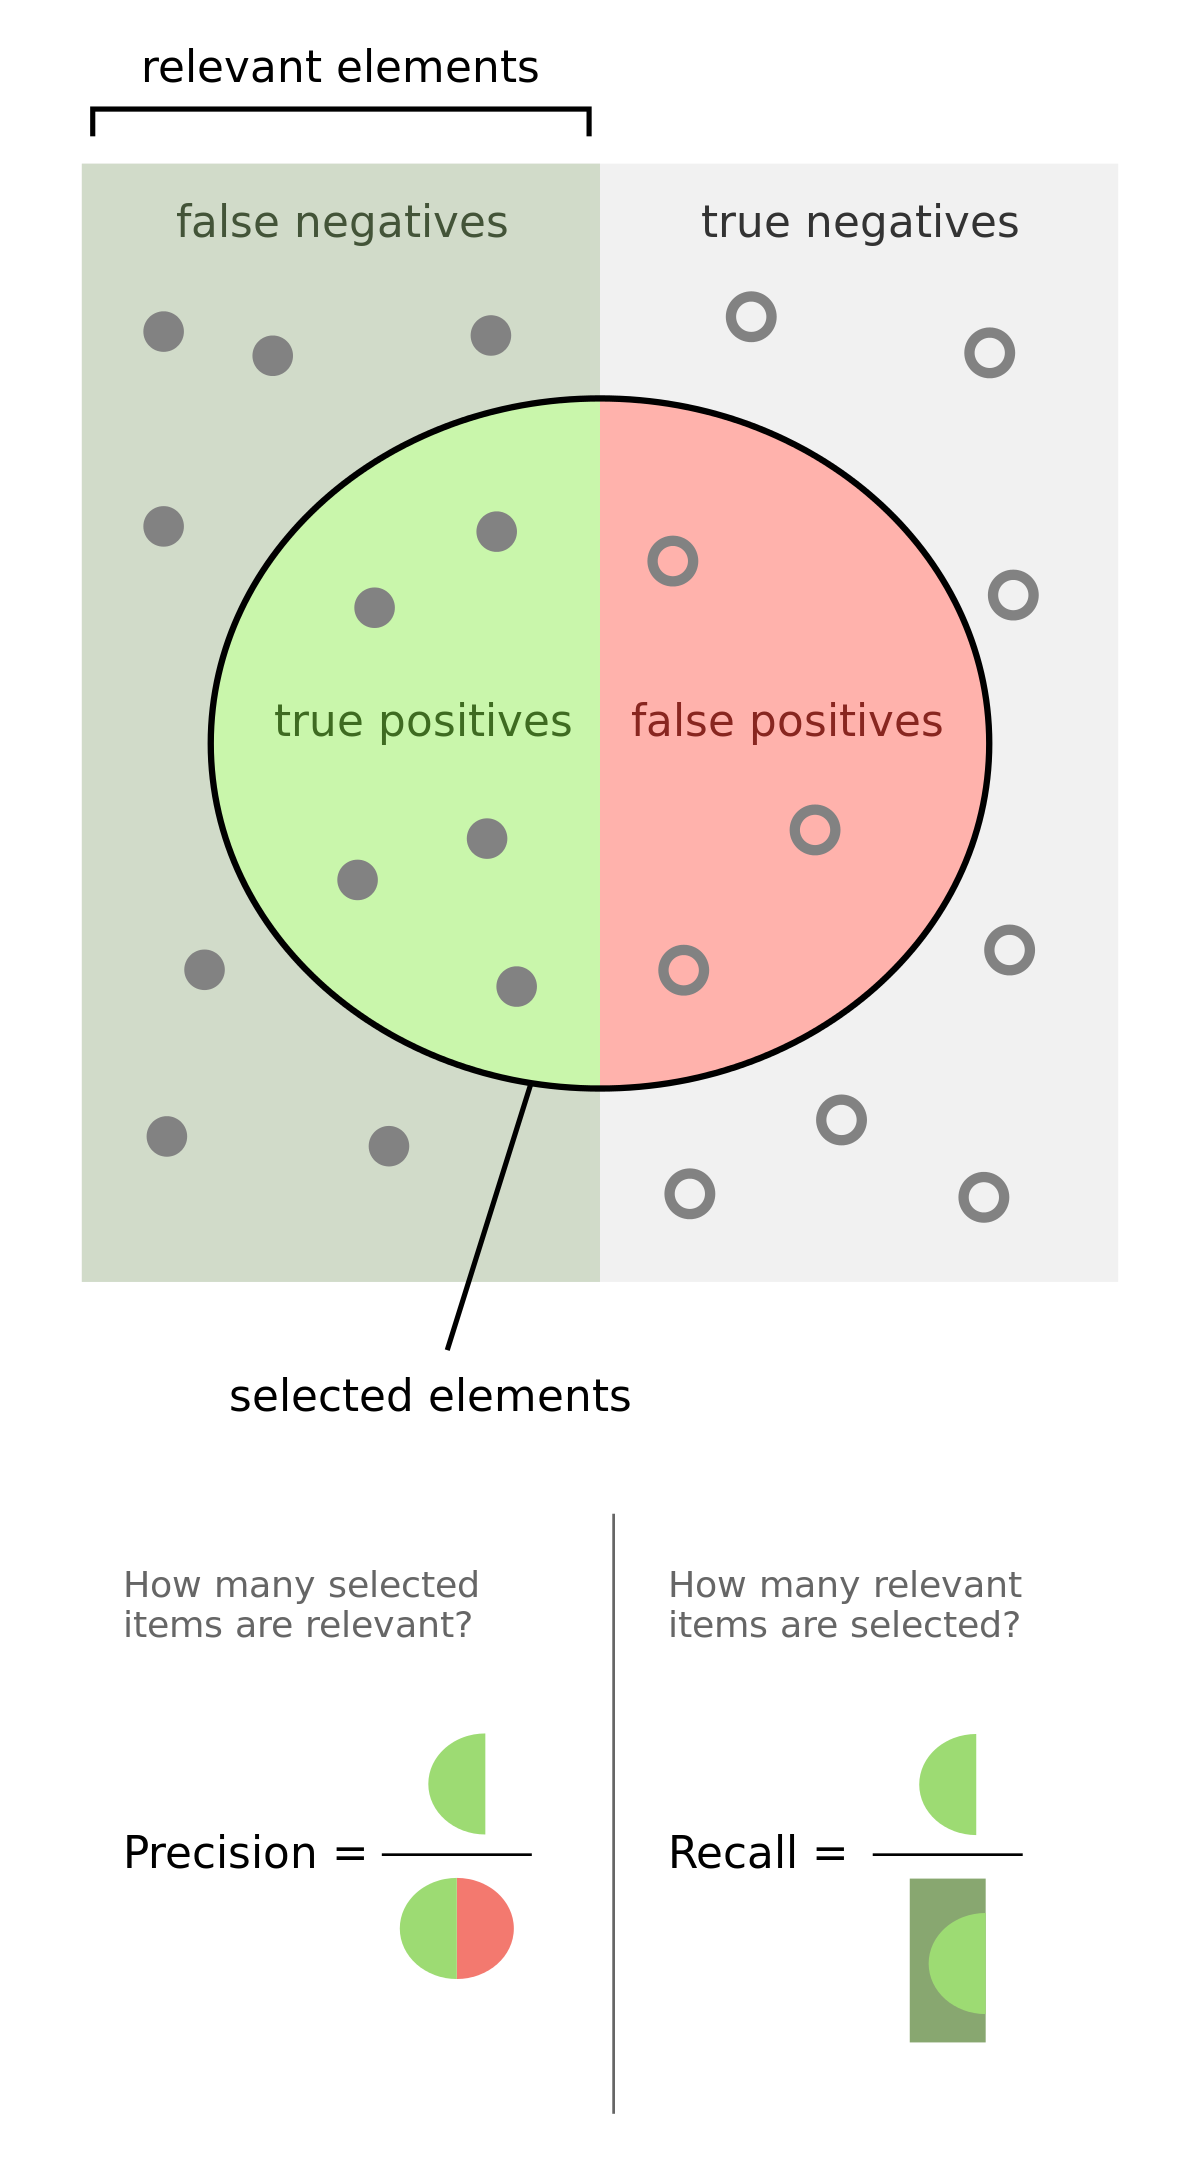

In [60]:
# Precision ve Recall'un ne anlama geldiğine ait görsel
from IPython.display import Image
Image("precision-recall.png", width = 400, height = 800)